<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/ricard/Easymoney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE

 
## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff). 

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado. 
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**, 

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?
 
¿Impactamos a todos lo segmentos indicados?


# Importación de librerías

In [1]:
import sys
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

from sklearn import model_selection
import xgboost as xgb

from scipy import stats
from datetime import datetime

import random
import json
from pandas import json_normalize

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación dataset

In [2]:
file_dir = "/content/drive/MyDrive/NUCLIO/TFM  Data Science/datasets_TFM_y_diccionario/"

In [3]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"


file_diccionario_tablas ="diccionario_tablas.xlsx"

In [4]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

diccionario_tablas_raw = pd.read_excel(file_dir + file_diccionario_tablas)

# 2.- DATA UNDERSTANDING

## 2.1.- Análisis univariante de datos

### Sales

* pk_sale: Identificador de venta - (primary key)
* cid: Identificador de cliente - (foreing key)
* month_sale: Mes de venta. Mes en el que se contrata un producto.
* product_ID: Identificador de producto  - (foreing key)
* net_margin: Margen neto generado por la venta ($)

In [5]:
# Análisis inicial de sales

sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB


In [6]:
sales_raw.head()

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin
0,0,6666,33620,2018-05-01,2335,952.9
1,1,6667,35063,2018-06-01,2335,1625.2
2,2,6668,37299,2018-02-01,2335,1279.7
3,3,6669,39997,2018-02-01,2335,1511.9
4,4,6670,44012,2018-02-01,2335,1680.3


In [7]:
sales_raw.describe(include = ['object'])

,month_sale
count,240773
unique,16
top,2018-10-01
freq,27693


In [8]:
sales_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_sale,cid,product_ID,net_margin
count,240773.000000,240773.000000,2.407730e+05,240773.000000,240773.000000
mean,120386.000000,127052.000000,1.363934e+06,3945.408202,606.878164
std,69505.322519,69505.322519,1.751721e+05,1632.821700,1735.806089
min,0.000000,6666.000000,1.589100e+04,1119.000000,25.000000
25%,60193.000000,66859.000000,1.301012e+06,2312.000000,61.400000
50%,120386.000000,127052.000000,1.409253e+06,4657.000000,69.100000
75%,180579.000000,187245.000000,1.475320e+06,4657.000000,79.200000
max,240772.000000,247438.000000,1.553571e+06,9001.000000,18466.400000


In [9]:
sales_raw.isnull().sum()

Unnamed: 0    0
pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

In [10]:
sales_raw[sales_raw.duplicated()]

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin


In [11]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
# Cambiar tipo de month_sale a fecha
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)


### Product Description

* pk_product_ID	= Identificador de producto - (primary key)
* product_desc	= Descripción del producto
* family_product	= Vertical del producto. Grupo al que pertenece.

In [12]:
# Análisis inicial de product description

product_description_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 544.0+ bytes


In [13]:
product_description_raw

,Unnamed: 0,pk_product_ID,product_desc,family_product
0,0,4657,em_acount,account
1,1,3819,debit_card,payment_card
2,2,1364,pension_plan,pension_plan
3,3,2234,payroll,account
4,4,2235,payroll_account,account
5,5,8871,emc_account,account
6,6,2312,credit_card,payment_card
7,7,2335,short_term_deposit,investment
8,8,2336,long_term_deposit,investment
9,9,2673,securities,investment


In [14]:
product_description_raw.describe(include = ['object'])

,product_desc,family_product
count,13,13
unique,13,5
top,em_acount,account
freq,1,4


In [15]:
product_description_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_product_ID
count,13.00000,13.000000
mean,6.00000,3614.538462
std,3.89444,2564.251438
min,0.00000,1119.000000
25%,3.00000,2235.000000
50%,6.00000,2336.000000
75%,9.00000,4033.000000
max,12.00000,9001.000000


In [16]:
product_description_raw.isnull().sum()

Unnamed: 0        0
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64

In [17]:
product_description_raw[product_description_raw.duplicated()]

,Unnamed: 0,pk_product_ID,product_desc,family_product


In [18]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed

### Customer Sociodemographics

* pk_cid =	Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* deceased =	Indicador de fallecimiento
* gender =	Sexo del cliente
* region_code =	Provincia de residencia del cliente (para ES)
* salary =	Ingresos brutos de la unidad familiar
* country_id =	País de residencia del cliente
* age =	Edad del cliente

In [19]:
customer_sociodemographics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [20]:
customer_sociodemographics_raw.head()

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [21]:
customer_sociodemographics_raw.describe(include = ['object'])

,pk_partition,country_id,gender,deceased
count,5962924,5962924,5962899,5962924
unique,17,41,2,2
top,2019-05,ES,H,N
freq,442995,5960672,3087502,5961849


In [22]:
customer_sociodemographics_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,region_code,age,salary
count,5.962924e+06,5.962924e+06,5.960660e+06,5.962924e+06,4.421820e+06
mean,7.155425e+06,1.234930e+06,2.581440e+01,2.976042e+01,1.155833e+05
std,3.920784e+06,1.623020e+05,1.359566e+01,1.198038e+01,2.000066e+05
min,0.000000e+00,1.589100e+04,1.000000e+00,2.000000e+00,1.202730e+03
25%,4.240386e+06,1.112532e+06,1.300000e+01,2.200000e+01,6.141532e+04
50%,7.499346e+06,1.231097e+06,2.800000e+01,2.500000e+01,8.844147e+04
75%,1.020142e+07,1.352339e+06,3.600000e+01,3.400000e+01,1.313092e+05
max,1.364731e+07,1.553689e+06,5.200000e+01,1.050000e+02,2.889440e+07


In [23]:
customer_sociodemographics_raw.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

In [24]:
customer_sociodemographics_raw["country_id"].value_counts().head(10)

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
Name: country_id, dtype: int64

In [25]:
# ACCIONES CUSTOMER SOCIODEMOGRAPHICS

# Gestionar nulos: (Culebra: tenemos modelo de clasificación así que lo que haremos será ponerles valores extremos)
#     region_code
#     gender
#     salary
# gender > Transformar a 1 y 0
# deceased > Transformar a 1 y 0
# country_id > Transformar a boolean "ES" Sí/No


### Customer Commercial Activity

* pk_cid = Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* entry_channel =	Canal de captación del cliente
* entry_date =	Fecha en la que realizó la primera contratación a través de easyMoney
* segment =	Segmento comercial del cliente
* active_customer =	Indicador de actividad del cliente en la app EasyMoney

In [26]:
customer_commercial_activity_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


In [27]:
customer_commercial_activity_raw.head()

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [28]:
customer_commercial_activity_raw.describe(include = ['object'])

,pk_partition,entry_date,entry_channel,segment
count,5962924,5962924,5829891,5828980
unique,17,53,68,3
top,2019-05,2016-10,KHE,03 - UNIVERSITARIO
freq,442995,382473,3113947,3900166


In [29]:
customer_commercial_activity_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,active_customer
count,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,4.033845e-01
std,3.920784e+06,1.623020e+05,4.905767e-01
min,0.000000e+00,1.589100e+04,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00
75%,1.020142e+07,1.352339e+06,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00


In [30]:
customer_commercial_activity_raw.isnull().sum()

Unnamed: 0              0
pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [31]:
customer_commercial_activity_raw["segment"].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [32]:
customer_commercial_activity_raw["entry_channel"].value_counts()

KHE    3113947
KFC     890620
KHQ     590280
KAT     416084
KHK     230197
        ...   
KEJ          8
KHS          5
KDA          2
KFP          2
KDS          1
Name: entry_channel, Length: 68, dtype: int64

In [33]:
# ACCIONES CUSTOMER COMMERCIAL ACTIVITY**


# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de active_customer a boolean
# Establecer primary key como index?
# Gestionar nulos: 
#     entry_channel      
#     segment            
# Cambiar tipo de entry_date a fecha
# Disgregar entry_date en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)
# entry_channel > OneHotEncoding o FrecuencyEncoding
# segment > OneHotEncoding

### Customer Products

- pk_cid =	Identificador de cliente
- pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
- credit_card =	Tenencia de tarjetas de crédito
- debit_card =	Tenencia de tarjetas de débito
- em_account_p =	Tenencia de Cuenta easyMoney+
- em_account_pp =	Tenencia de Cuenta easyMoney++
- em_acount =	Tenencia de Cuenta easyMoney
- emc_account =	Tenencia de Cuenta easyMoney Crypto
- funds =	Tenencia de Fondos de inversión
- loans =	Tenencia de Préstamos
- long_term_deposit =	Tenencia de Depósitos a largo plazo
- mortgage =	Tenencia de Mortgage
- payroll =	Tenencia de Domiciliaciones 
- payroll_account =	Tenencia de Cuenta bonificada por domiciliaciones
- pension_plan =	Tenencia de Plan de pensiones
- securities =	Tenencia de Valores
- short_term_deposit =	Tenencia de Short-term deposits

In [34]:
customer_products_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [35]:
customer_products_raw.head()

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [36]:
customer_products_raw.describe(include = ['object'])

,pk_partition
count,5962924
unique,17
top,2019-05
freq,442995


In [37]:
customer_products_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
count,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5962924.0,5.962924e+06,5.962863e+06,5.962863e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,2.581619e-03,7.848498e-05,5.433576e-05,3.370662e-03,3.711770e-03,1.688098e-02,0.0,1.188444e-02,3.451144e-02,3.652641e-02,5.524471e-02,5.483233e-02,9.441140e-02,5.701901e-06,7.348076e-01
std,3.920784e+06,1.623020e+05,5.074401e-02,8.858828e-03,7.371080e-03,5.795948e-02,6.081113e-02,1.288255e-01,0.0,1.083660e-01,1.825388e-01,1.875960e-01,2.284573e-01,2.276527e-01,2.924002e-01,2.387859e-03,4.414356e-01
min,0.000000e+00,1.589100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.020142e+07,1.352339e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [38]:
customer_products_raw.isnull().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [39]:
# ACCIONES CUSTOMER PRODUCTS

# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de columnas booleanas a boolean?
# Establecer primary key como index?
# Gestionar nulos: 
#     payroll                     
#     pension_plan
# Eliminar em_account_pp, no hay datos

# Cambiar tipo de payroll y pension_plan a int

### Análisis del target

In [40]:
# Para el modelo de propensión a compra (supervisado > clasificación) trataremos de averiguar la propensión a compra de ciertos productos de cada cliente
# El target puede ser:
#  - em_acount = 4.381.602  (73,48%)
#  - pension_plan = 2.178.020 (36,53%) ** Target interesante por negocio
#  - debit_card = 562.968 (9,44%)
#  - payroll_account = 329.420 (5,52%)


# Analizando el revenue de cada producto:
#  - pension_plan = media >5200€ ** Target interesante por revenue
#  - loans = media > 2000€
#  - mortgage = media > 2000€ 
#
#
# El producto "pension_plan" resulta interesante ya que un 74% de la bbdd todavía no ha es cliente y es el que más beneficios genera a la compañía


TARGET = "pension_plan"

In [41]:
for i in ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities','long_term_deposit', 'em_account_pp','credit_card', 'payroll', 'pension_plan', 'payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']:
    suma_productos = customer_products_raw[i].sum()
    print (f"Suma de {i} = {suma_productos} . La media es de {round((suma_productos/customer_products_raw.shape[0])*100,2)}%")
    

Suma de short_term_deposit = 15394 . La media es de 0.26%
Suma de loans = 468 . La media es de 0.01%
Suma de mortgage = 324 . La media es de 0.01%
Suma de funds = 20099 . La media es de 0.34%
Suma de securities = 22133 . La media es de 0.37%
Suma de long_term_deposit = 100660 . La media es de 1.69%
Suma de em_account_pp = 0 . La media es de 0.0%
Suma de credit_card = 70866 . La media es de 1.19%
Suma de payroll = 205787.0 . La media es de 3.45%
Suma de pension_plan = 217802.0 . La media es de 3.65%
Suma de payroll_account = 329420 . La media es de 5.52%
Suma de emc_account = 326961 . La media es de 5.48%
Suma de debit_card = 562968 . La media es de 9.44%
Suma de em_account_p = 34 . La media es de 0.0%
Suma de em_acount = 4381602 . La media es de 73.48%


### Distribución de las variables

In [42]:
def obtener_lista_variables(dataset):
  lista_numericas =[]
  lista_boolean = []
  lista_categoricas = []
  for i in dataset:
    if ( (dataset[i].dtype.kind == "f") | (dataset[i].dtype.kind == "i") | (dataset[i].dtype.kind == "u") ) & (len(dataset[i].unique()) != 2) & (i not in TARGET): #La columna es "f" o "i" (float o intiger)(numérica) y el nº de valores diferente de 2 (no es booleano) y que la columna no sea PRECIO (nuestro target)
       lista_numericas.append(i)
    if ( (dataset[i].dtype.kind == "f") | (dataset[i].dtype.kind == "i") | (dataset[i].dtype.kind == "u") ) & (len(dataset[i].unique()) <= 2) & (i not in TARGET): #La columna es "f" o "i" (float o intiger)(numérica) y el nº de valores igual de 2 (es booleano) y que la columna no sea PRECIO (nuestro target)
       lista_boolean.append(i)
    if (dataset[i].dtype.kind == "O") & (i not in TARGET): #La columna es "O"(Objeto)(Categórica) y que la columna no sea PRECIO (nuestro target)
       lista_categoricas.append(i)
  return lista_numericas, lista_boolean, lista_categoricas

In [43]:
customer_commercial_activity_num, customer_commercial_activity_bool, customer_commercial_activity_cat = obtener_lista_variables(customer_commercial_activity_raw)
sales_num, sales_bool, sales_cat = obtener_lista_variables(sales_raw)
customer_sociodemographics_num, customer_sociodemographics_bool, customer_sociodemographics_cat = obtener_lista_variables(customer_sociodemographics_raw)
product_description_num, product_description_bool, product_description_cat = obtener_lista_variables(product_description_raw)

#### Variables de fechas

In [44]:
customer_commercial_activity_raw["entry_date"]

0          2018-01
1          2015-08
2          2015-08
3          2015-08
4          2015-08
            ...   
5962919    2016-08
5962920    2016-08
5962921    2016-08
5962922    2016-08
5962923    2019-05
Name: entry_date, Length: 5962924, dtype: object

In [45]:
sales_raw["month_sale"]

0         2018-05-01
1         2018-06-01
2         2018-02-01
3         2018-02-01
4         2018-02-01
             ...    
240768    2019-05-01
240769    2019-05-01
240770    2019-05-01
240771    2019-05-01
240772    2019-05-01
Name: month_sale, Length: 240773, dtype: object

#### Variables numéricas

In [46]:
sales_raw["product_ID"]
sales_raw["net_margin"]

0          952.9
1         1625.2
2         1279.7
3         1511.9
4         1680.3
           ...  
240768      56.7
240769      66.5
240770      73.0
240771      82.3
240772      84.4
Name: net_margin, Length: 240773, dtype: float64

In [47]:
customer_commercial_activity_num

['Unnamed: 0', 'pk_cid']

In [48]:
sales_num

['Unnamed: 0', 'pk_sale', 'cid', 'product_ID', 'net_margin']

In [49]:
customer_sociodemographics_num

['Unnamed: 0', 'pk_cid', 'region_code', 'age', 'salary']

In [50]:
product_description_num

['Unnamed: 0', 'pk_product_ID']

#### Variables categóricas

In [51]:
customer_commercial_activity_raw["entry_channel"]
customer_commercial_activity_raw["segment"]
customer_commercial_activity_raw["active_customer"]

0          1.0
1          0.0
2          0.0
3          0.0
4          1.0
          ... 
5962919    0.0
5962920    0.0
5962921    1.0
5962922    0.0
5962923    1.0
Name: active_customer, Length: 5962924, dtype: float64

In [52]:
customer_sociodemographics_raw["deceased"]	
customer_sociodemographics_raw["gender"]	
customer_sociodemographics_raw["region_code"]	
customer_sociodemographics_raw["salary"]	
customer_sociodemographics_raw["country_id"]	
customer_sociodemographics_raw["age"]	

0          35
1          23
2          23
3          22
4          23
           ..
5962919    22
5962920    23
5962921    47
5962922    22
5962923    37
Name: age, Length: 5962924, dtype: int64

In [53]:
product_description_raw["product_desc"]	
product_description_raw["family_product"]	

0          account
1     payment_card
2     pension_plan
3          account
4          account
5          account
6     payment_card
7       investment
8       investment
9       investment
10      investment
11            loan
12            loan
Name: family_product, dtype: object

# 3.- PRE PROCESSING

## Procesamiento de Sales

In [54]:
# Merge de Sales y Product Description
df_sales_raw = sales_raw.merge(product_description_raw, right_on = "pk_product_ID", left_on= "product_ID", how = "left")

In [55]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df_sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0_x    240773 non-null  int64  
 1   pk_sale         240773 non-null  int64  
 2   cid             240773 non-null  int64  
 3   month_sale      240773 non-null  object 
 4   product_ID      240773 non-null  int64  
 5   net_margin      240773 non-null  float64
 6   Unnamed: 0_y    240773 non-null  int64  
 7   pk_product_ID   240773 non-null  int64  
 8   product_desc    240773 non-null  object 
 9   family_product  240773 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 20.2+ MB


In [56]:
df_sales1 = df_sales_raw.copy()

In [57]:
# Eliminar columna Unnamed

df_sales1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df_sales1.drop("Unnamed: 0_y", axis = 1, inplace = True)

# Eliminar columna "pk_product_ID" duplicada tras el merge

df_sales1.drop("pk_product_ID", axis = 1, inplace = True)

In [58]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"

df_sales1.rename({"pk_sale": "sale_ID","cid": "customer_ID"},axis='columns',inplace = True)

In [59]:
# Establecer primary key como index

df_sales1.set_index("sale_ID",inplace = True)

In [60]:
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica

df_sales1["product_ID"] = df_sales1["product_ID"].astype("object")
df_sales1["customer_ID"] = df_sales1["customer_ID"].astype("object")

In [61]:
# Cambiar tipo de month_sale a fecha

df_sales1["month_sale"] = pd.to_datetime(df_sales1["month_sale"], format = "%Y/%m/%d")

In [62]:
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)

df_sales1["month_sales"] = df_sales1["month_sale"].dt.month
df_sales1["year_sales"] = df_sales1["month_sale"].dt.year

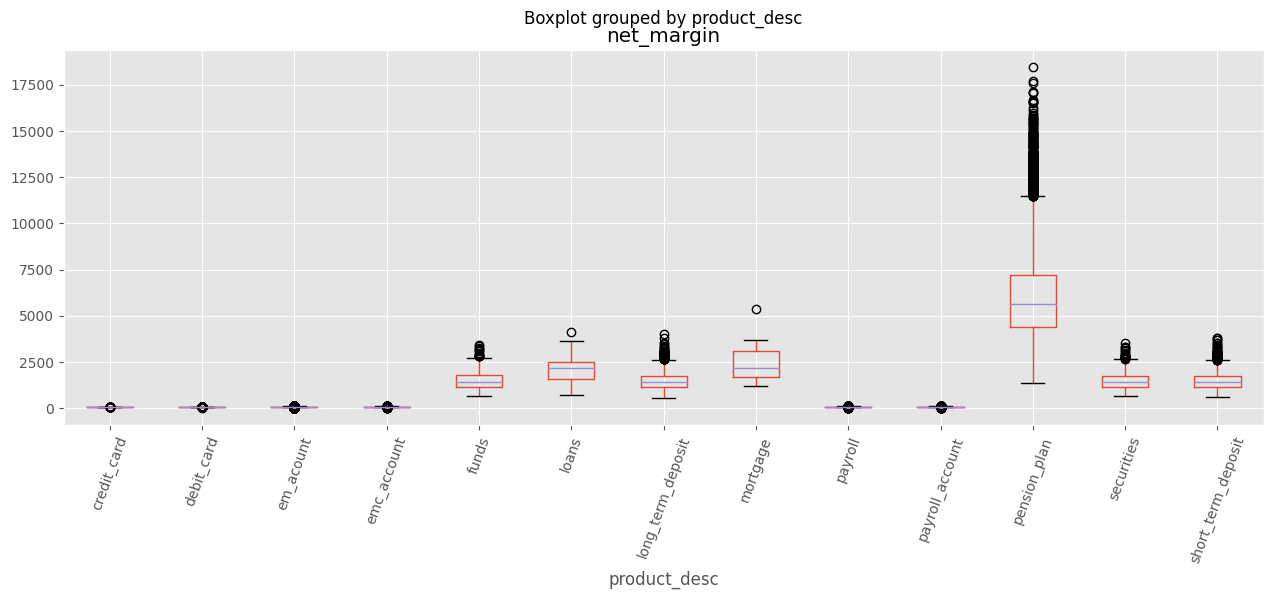

In [63]:
df_sales1.boxplot(column = "net_margin", by = "product_desc", figsize=(15,5))
plt.xticks(rotation=70);

In [64]:
df_sales1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 6666 to 247438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   customer_ID     240773 non-null  object        
 1   month_sale      240773 non-null  datetime64[ns]
 2   product_ID      240773 non-null  object        
 3   net_margin      240773 non-null  float64       
 4   product_desc    240773 non-null  object        
 5   family_product  240773 non-null  object        
 6   month_sales     240773 non-null  int64         
 7   year_sales      240773 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 16.5+ MB


## Procesamiento de Customers

In [65]:
# Merge de las tablas relacionadas con el cliente
df_raw = customer_commercial_activity_raw.merge(customer_sociodemographics_raw, on=["pk_cid","pk_partition"])\
            .merge(customer_products_raw, on=["pk_cid","pk_partition"])

In [66]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 30 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0_x        int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   entry_date          object 
 4   entry_channel       object 
 5   active_customer     float64
 6   segment             object 
 7   Unnamed: 0_y        int64  
 8   country_id          object 
 9   region_code         float64
 10  gender              object 
 11  age                 int64  
 12  deceased            object 
 13  salary              float64
 14  Unnamed: 0          int64  
 15  short_term_deposit  int64  
 16  loans               int64  
 17  mortgage            int64  
 18  funds               int64  
 19  securities          int64  
 20  long_term_deposit   int64  
 21  em_account_pp       int64  
 22  credit_card         int64  
 23  payroll             float64
 24  pension_plan        floa

In [67]:
df1 = df_raw.copy()

In [68]:
#  Eliminamos las columnas "Unnamed"
df1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df1.drop("Unnamed: 0_y", axis = 1, inplace = True)
df1.drop("Unnamed: 0", axis = 1, inplace = True)

In [69]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
df1.rename({"pk_cid": "customer_ID","pk_partition": "partition_ID"},axis='columns',inplace = True)

### Atributos de baja varianza

In [70]:
df1["em_account_p"].value_counts(normalize = True)*100

0    99.99943
1     0.00057
Name: em_account_p, dtype: float64

In [71]:
df1["em_account_pp"].value_counts(normalize = True)*100

0    100.0
Name: em_account_pp, dtype: float64

In [72]:
df1["country_id"].value_counts(normalize=True)*100

ES    99.962233
GB     0.007396
FR     0.003773
DE     0.003337
US     0.003270
CH     0.003253
BR     0.001459
BE     0.001358
VE     0.001325
IE     0.001140
MX     0.000973
AT     0.000855
AR     0.000855
PL     0.000822
IT     0.000755
MA     0.000570
CL     0.000503
CN     0.000470
CA     0.000369
LU     0.000285
ET     0.000285
QA     0.000285
CI     0.000285
SA     0.000285
CM     0.000285
SN     0.000285
MR     0.000285
NO     0.000285
RU     0.000285
CO     0.000285
GA     0.000285
GT     0.000285
DO     0.000285
SE     0.000268
DJ     0.000184
PT     0.000184
JM     0.000184
RO     0.000151
HU     0.000134
DZ     0.000117
PE     0.000067
Name: country_id, dtype: float64

In [73]:
country_id_not_ES = df1[df1["country_id"] != "ES"]["country_id"].value_counts().index

In [74]:
df1["country_id"] = df1["country_id"].replace(country_id_not_ES, 0)

In [75]:
df1["country_id"] = df1["country_id"].replace("ES", 1)

In [76]:
df1["country_id"].value_counts(normalize=True)*100

1    99.962233
0     0.037767
Name: country_id, dtype: float64

In [77]:
# Eliminamos variables de baja varianza
del df1['em_account_pp']
del df1['em_account_p']
del df1['country_id']

### Gestión de nulos

In [78]:
df1.isnull().sum()

customer_ID                 0
partition_ID                0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1541104
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
credit_card                 0
payroll                    61
pension_plan               61
payroll_account             0
emc_account                 0
debit_card                  0
em_acount                   0
dtype: int64

In [79]:
# Eliminamos valores nulos de "payroll" y "pension_plan"

df1.dropna(subset = ['pension_plan'], inplace = True)

In [80]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df1["salary"].describe())
df1["salary"].fillna(value = 0, inplace = True)

print(df1["gender"].value_counts(normalize = True))
df1["gender"].fillna(value = 2, inplace = True)

print(df1["region_code"].describe())
df1["region_code"].fillna(value = 100, inplace = True)

count    4.421771e+06
mean     1.155836e+05
std      2.000077e+05
min      1.202730e+03
25%      6.141537e+04
50%      8.844147e+04
75%      1.313092e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517787
V    0.482213
Name: gender, dtype: float64
count    5.960599e+06
mean     2.581436e+01
std      1.359565e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.800000e+01
75%      3.600000e+01
max      5.200000e+01
Name: region_code, dtype: float64


#### Segment (sustituir por valores exisitnetes en otras particiones)

In [81]:
#array con los ids que tienen nulos
ids_nullsegment_unique=df1[(df1['segment'].isnull()==True)]['customer_ID'].unique()

In [82]:
len(ids_nullsegment_unique)

133281

In [83]:
valores_nulos_segment=df1[(df1.customer_ID.isin(ids_nullsegment_unique))&(df1['segment'].notnull())&(df1['partition_ID']== "2019-05")][['customer_ID','segment']]

In [84]:
dict_nulos_segment=dict(zip(valores_nulos_segment['customer_ID'],valores_nulos_segment['segment']))

#### Entry_Chanel (sustituir por valores exisitnetes en otras particiones)

In [85]:
#array con los ids que tienen nulos
ids_nullentrychannel_unique=df1[(df1['entry_channel'].isnull()==True)]['customer_ID'].unique()

In [86]:
len(ids_nullentrychannel_unique)

132201

In [87]:
valores_nulos_entrychannel=df1[(df1.customer_ID.isin(ids_nullentrychannel_unique))&(df1['entry_channel'].notnull())&(df1['partition_ID']=='2019-05')][['customer_ID','entry_channel']]

In [88]:
dict_nulos_entrychannel=dict(zip(valores_nulos_entrychannel['customer_ID'],valores_nulos_entrychannel['entry_channel']))

In [89]:
df1.set_index('customer_ID',inplace = True)

In [90]:
df1['segment'].fillna(dict_nulos_segment,inplace=True)
df1['entry_channel'].fillna(dict_nulos_entrychannel,inplace=True)

In [91]:
df1.isnull().sum()

partition_ID              0
entry_date                0
entry_channel         13254
active_customer           0
segment               13373
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                   0
pension_plan              0
payroll_account           0
emc_account               0
debit_card                0
em_acount                 0
dtype: int64

In [92]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df1['entry_channel'].fillna(value='ZZZ',inplace=True)

In [93]:
df1.isnull().sum()

partition_ID          0
entry_date            0
entry_channel         0
active_customer       0
segment               0
region_code           0
gender                0
age                   0
deceased              0
salary                0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
dtype: int64

### Transformación de fechas

In [94]:
# Extraemos año, mes y trimestre de partition ID
df1['partition_date'] = pd.to_datetime(df1['partition_ID'])

df1['partition_year'] = df1['partition_date'].dt.year
df1['partition_month'] = df1['partition_date'].dt.month
df1['partition_quarter'] = df1['partition_date'].dt.quarter

In [95]:
# Definimos las primary keys como índice
df1.reset_index(inplace = True)
df1.set_index(["customer_ID","partition_ID"],inplace = True)

In [96]:
# Transformamos "entry_date" a fecha y extraemos año, mes y trimestre
df1['entry_date']=pd.to_datetime(df1['entry_date'])

df1['entry_year'] = df1['entry_date'].dt.year
df1['entry_month'] = df1['entry_date'].dt.month
df1['entry_quarter'] = df1['entry_date'].dt.quarter

### Tranformación de numéricas

In [97]:
# Cambiamos el type de las variables con float a int (active_customer, payroll y pension_plan), excepto salary, que si que es float

variables_to_int = ['active_customer', 'payroll', 'pension_plan']

df1[variables_to_int] = df1[variables_to_int].applymap(int)

### Transformación de categóricas

In [98]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [99]:
# OHE "entry_channel"

df1 = OHE(df1, "entry_channel")

In [100]:
# OHE segment

df1 = OHE(df1, "segment")

In [101]:
# OHE segment

df1 = OHE(df1, "region_code")

In [102]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df1["gender"] = df1["gender"].replace("H", 1) # H es de Hembras
df1["gender"] = df1["gender"].replace("V", 0) # V es de Varones

In [103]:
# deceased --> 1 = Fallecido, 0 = No fallecido

df1["deceased"] = df1["deceased"].replace("N", 0) # H es de Hembras
df1["deceased"] = df1["deceased"].replace("S", 1) # H es de Hembras

In [104]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5962863 entries, (1375586, '2018-01') to (1550586, '2019-05')
Columns: 152 entries, entry_date to region_code_100.0
dtypes: datetime64[ns](2), float64(1), int64(23), uint8(126)
memory usage: 1.9+ GB


In [ ]:
# FALTA

# 1.9 GB de memory usage es muchisimo
# Tras análisis, eliminar entry_date, entry_channel, segment y partition_date